<a href="https://colab.research.google.com/github/tmdcks1103/Machine-Learning-Programming/blob/main/11%EC%A3%BC%EC%B0%A8/AE_Creditcard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사기 거래 탐지 프로세스

### 오토 인코더라는 딥러닝 모델을 사용하여 신용카드 거래 데이터에서 이상 탐지

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [27]:
# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/11wnck/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [28]:
# 데이터 형태 확인 (행, 열)

df.shape

(284807, 31)

In [29]:
# 결측치 확인

df.isnull().values.any()

np.False_

/tmp/ipython-input-3359888635.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


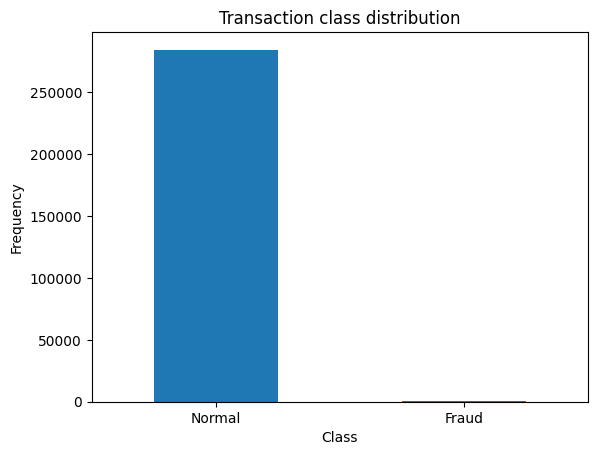

In [30]:
# 시각화를 위한 레이블 정의
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

# 해당 그래프를 통해 데이터의 불균형 정도를 파악

In [33]:
# 사기/정상 데이터 저장
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

# 각각의 데이터 개수 확인
print("사기 거래 건수:", frauds.shape)
print("정상 거래 건수:", normal.shape)


사기 거래 건수: (492, 31)
정상 거래 건수: (284315, 31)


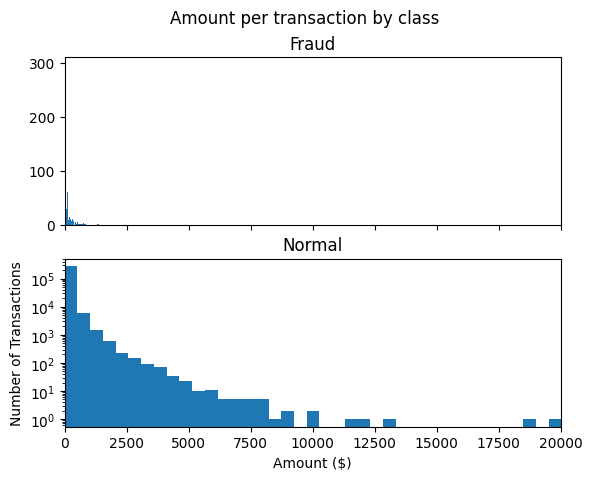

In [34]:
# 거래 클래스별 분포 시각화

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

# 사기 거래
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')
# 정상 거래
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

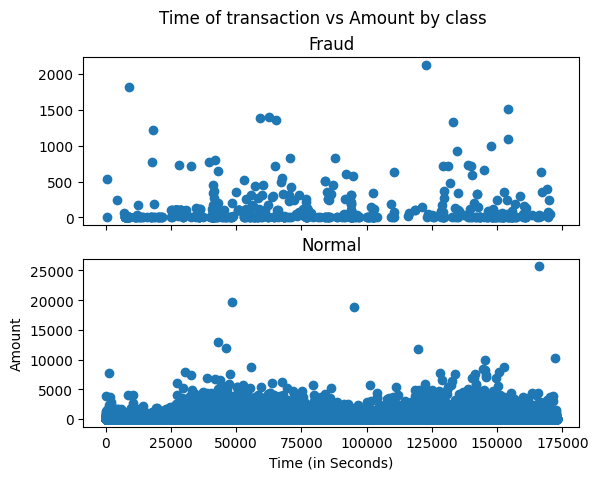

In [35]:
# 거래 클래스별 Time/Amount 관계 시각화 (산점도)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
# 사기 거래
ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')
# 정상 거래
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [38]:
# 데이터 전처리
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [39]:
# 훈련/테스트 데이터 분리

# 모델을 오직 정상 거래기록으로만 훈련
# 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가

RANDOM_SEED = 42

# 재현성을 위함임

In [40]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

In [41]:
# 테스트 레이블을 남겨두는 이유는 나중에 정확도를 비교하기 위해서임
# 오토인코더 모델

input_dim = X_train.shape[1]
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [42]:
# 모델 학습
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split = 0.1)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.1033 - val_loss: 0.8873
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9142 - val_loss: 0.8677
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8935 - val_loss: 0.8604
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8787 - val_loss: 0.8500
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8782 - val_loss: 0.8446
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8505 - val_loss: 0.8416
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8606 - val_loss: 0.8388
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8419 - val_loss: 0.8375
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8550 - val_loss: 0.8356
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8439 - val_loss: 0.8347
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8583 - val_loss: 0.8333
Epoch 12/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

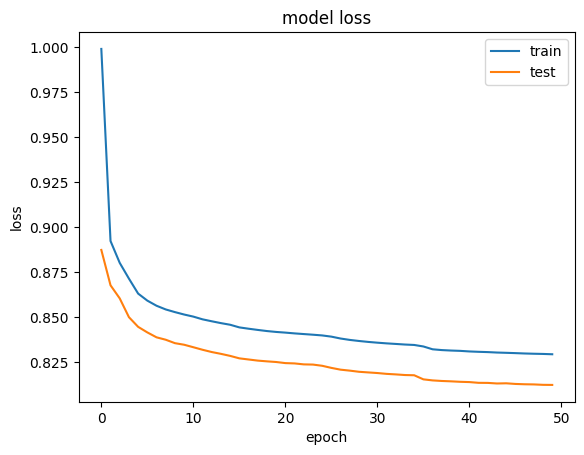

In [43]:
# 시각화 (Loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [44]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.854352,0.001720
std,3.725526,0.041443
min,0.048884,0.000000
25%,0.263098,0.000000
50%,0.439330,0.000000
75%,0.709754,0.000000
max,258.788057,1.000000


In [45]:
# 상위 5개 데이터 확인
error_df.head()

,reconstruction_error,true_class
43428,80.727886,1
49906,0.901948,0
29474,0.246145,0
276481,0.374813,0
278846,0.201047,0


In [46]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프로를 보고 결정
# 임계값 설정
threshold = 15

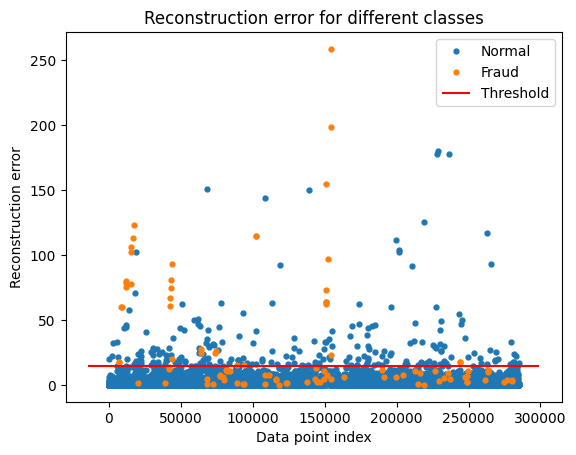

In [47]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

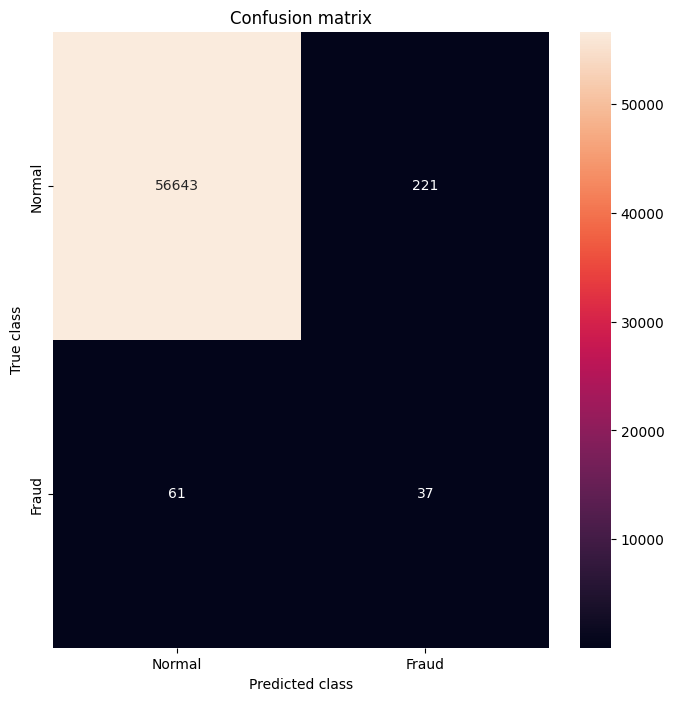

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.14      0.38      0.21        98

    accuracy                           1.00     56962
   macro avg       0.57      0.69      0.60     56962
weighted avg       1.00      1.00      1.00     56962



In [48]:
# 각 그룹(0: Normal, 1: Fraud)별로 복원 오차 산점도 그리기
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))